# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_complexloop_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Aug25-1659'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    "PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
    "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
    "contrastive"
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
from concord.simulation import (
    SimConfig, TrajectoryConfig, BatchConfig, Simulation
)

# ──────────────── Inputs ────────────────
seed = 42
state_type = "trajectory"
batch_type = "batch_specific_features"
distribution = "normal"

# ─────────────── SimConfig ───────────────
sim_cfg = SimConfig(
    n_cells=1000,
    n_genes=2000,
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ───────────── TrajectoryConfig (StateConfig) ─────────────
state_cfg = TrajectoryConfig(
    distribution=distribution,
    level=10.0,
    min_level=0.0,
    dispersion=7.0,
    program_structure="linear_bidirectional",
    program_on_time_fraction=0.2,
    program_num=8,
    cell_block_size_ratio=0.2,
    loop_to=[1, 3, 5],
)

# ─────────────── BatchConfig ───────────────
batch_cfg = BatchConfig(
    n_batches=1,
    effect_type=batch_type,
    distribution=distribution,
    level=[10.0],        # length must match n_batches
    dispersion=[5.0],
)

# ─────────────── Simulation ───────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


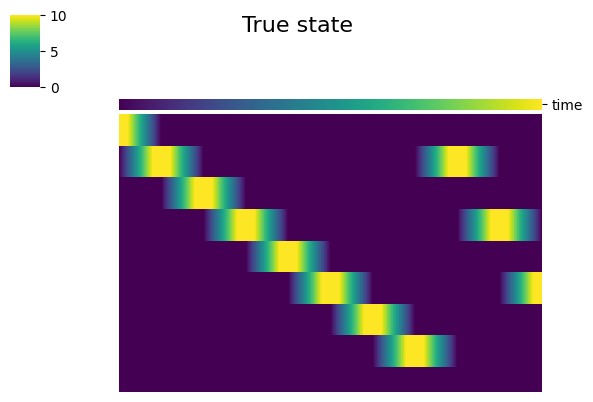

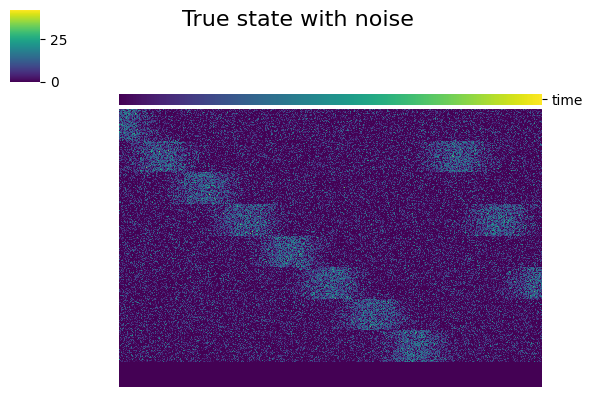

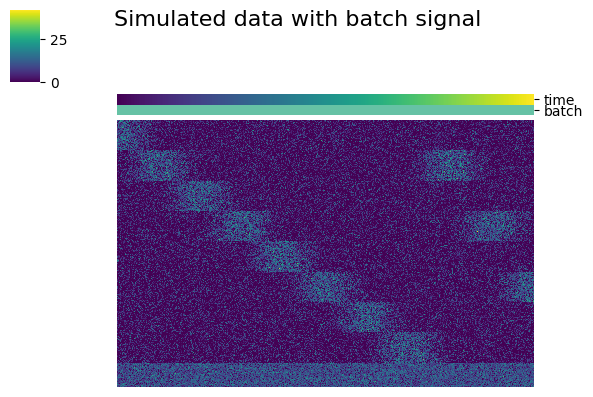

In [31]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

### Run dimension reduction

In [ ]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']

In [ ]:
concord_kwargs = {
    'batch_size': 64,
    'n_epochs': 15,
    'preload_dense': True,
    'verbose': False,
}
latent_dim = 15
bench_res = ccd.bm.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=run_methods,
    n_components=latent_dim,
    seed=seed,
    device=device,
    save_dir=save_dir,
    concord_kwargs=concord_kwargs,
)

Running zero-inflated factor analysis with N = 1000, D = 2200, K = 15
Param change below threshold 1.000e-02 after 15 iterations


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Calculating PHATE...
  Running PHATE on 1000 observations and 2200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.23 seconds.
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 0.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.06 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.37 seconds.
Calculated PHATE in 0.81 seconds.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is re

In [42]:
# Run umap and PCA for all latent embeddings
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=latent_dim, random_state=seed)


Running UMAP and PCA for no_noise
Running UMAP and PCA for wt_noise
Running UMAP and PCA for concord_hcl
Running UMAP and PCA for concord_knn
Running UMAP and PCA for DiffusionMap
Running UMAP and PCA for NMF
Running UMAP and PCA for FactorAnalysis
Running UMAP and PCA for FastICA
Running UMAP and PCA for LDA
Running UMAP and PCA for ZIFA
Running UMAP and PCA for scVI
Running UMAP and PCA for PHATE
Running UMAP and PCA for contrastive


In [43]:
# Save the pandas DataFrame with the results
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
print("Data saved to", data_dir / f"adata_{file_suffix}.h5ad")
bench_res.to_csv(save_dir / f"benchmark_results_{file_suffix}.csv", index=False)
print("Benchmark results saved to", save_dir / f"benchmark_results_{file_suffix}.csv")

Data saved to ../data/simulation_complexloop_singlebatch/adata_Jul18-2218.h5ad
Benchmark results saved to ../save/dev_simulation_complexloop_singlebatch-Jul18/benchmark_results_Jul18-2218.csv


In [60]:
state_key

'time'

concord.plotting.pl_embedding - INFO - Plotting no_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting DiffusionMap with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting NMF with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting FactorAnalysis with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting FastICA with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting LDA with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting ZIFA with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scVI with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting PHATE with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in UMAP


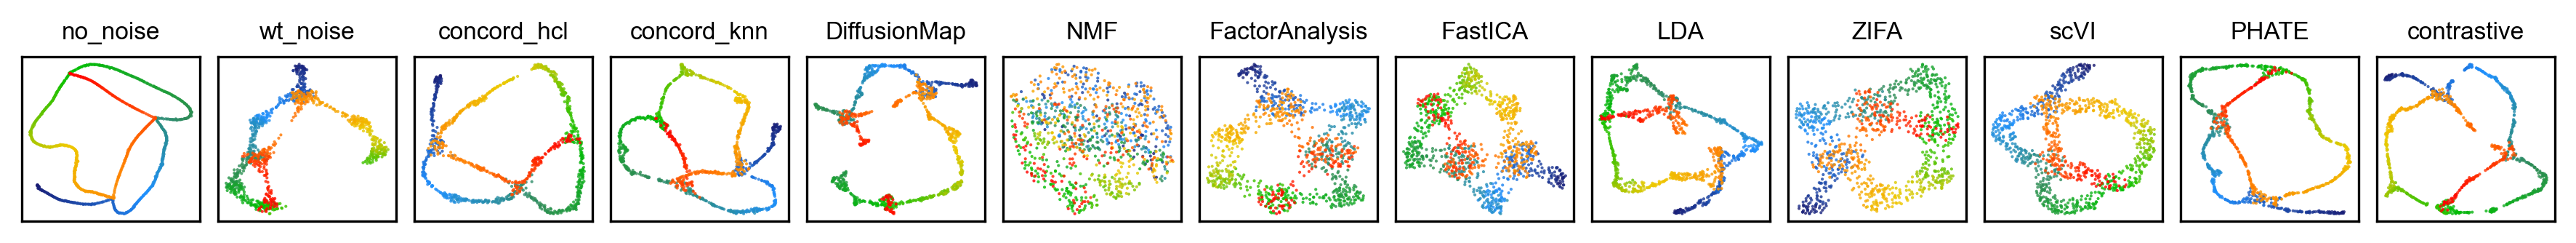

In [62]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}



color_bys = [state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['UMAP']
#basis_types = ['KNN']
font_size=8
point_size=4
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = 1
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

pal = {state_key: 'BlueGreenRed'}
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [55]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


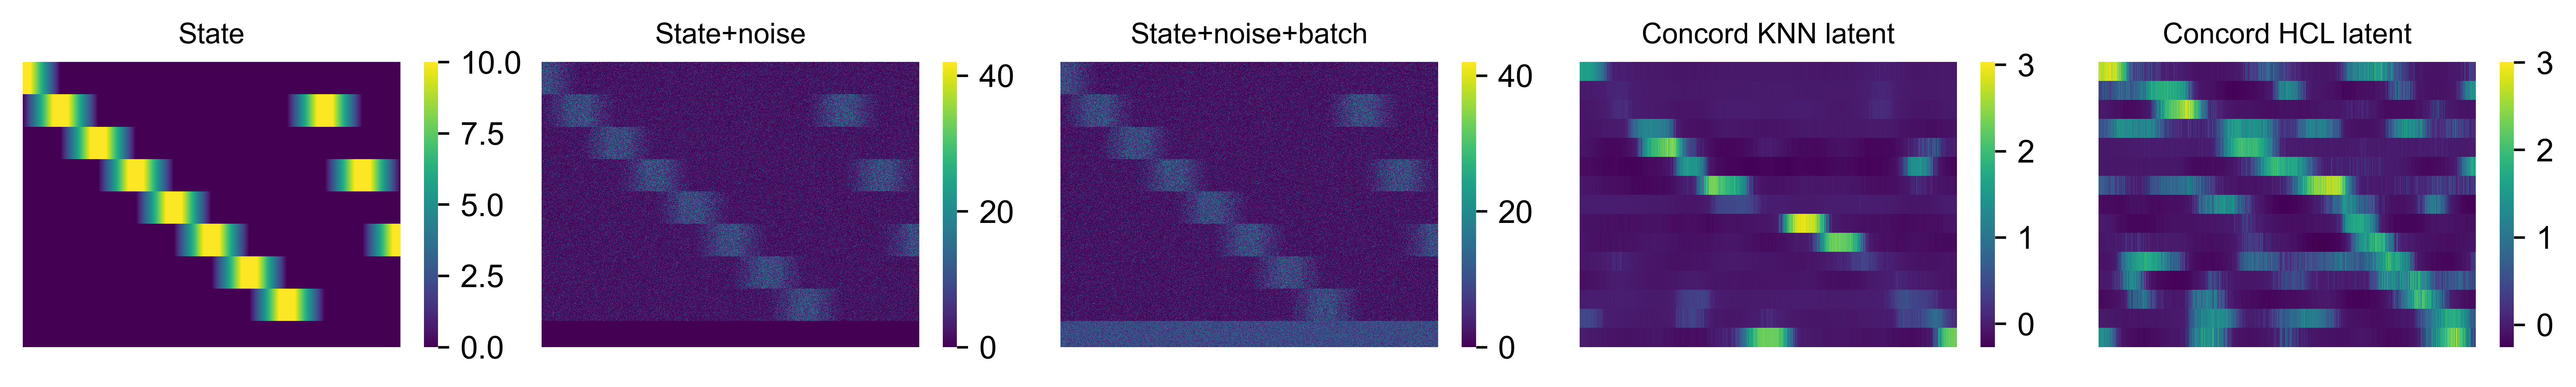

In [63]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [59]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
print("Data saved to", data_dir / f"adata_{file_suffix}.h5ad")
print("State data saved to", data_dir / f"adata_state_{file_suffix}.h5ad")

Data saved to ../data/simulation_complexloop_singlebatch/adata_Jul18-2218.h5ad
State data saved to ../data/simulation_complexloop_singlebatch/adata_state_Jul18-2218.h5ad


# Evaluation

In [5]:
# adata = sc.read(data_dir / f"adata_Dec15-0906.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Dec15-0906.h5ad")
# adata = sc.read(data_dir / f"adata_Feb05-1924.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Feb05-1924.h5ad")
adata = sc.read(data_dir / f"adata_Jul18-2218.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul18-2218.h5ad")

In [6]:
adata.shape

(1000, 2200)

concord - INFO - Running Topology benchmark
concord - INFO - Computing persistent homology for no_noise


concord - INFO - Computing persistent homology for 1000 points in 2200 dimensions...
concord - INFO - Computing persistent homology for wt_noise
concord - INFO - Computing persistent homology for 1000 points in 2200 dimensions...
concord - INFO - Computing persistent homology for concord_hcl
concord - INFO - Computing persistent homology for 1000 points in 15 dimensions...
concord - INFO - Computing persistent homology for concord_knn
concord - INFO - Computing persistent homology for 1000 points in 15 dimensions...
concord - INFO - Computing persistent homology for DiffusionMap
concord - INFO - Computing persistent homology for 1000 points in 15 dimensions...
concord - INFO - Computing persistent homology for NMF
concord - INFO - Computing persistent homology for 1000 points in 15 dimensions...
concord - INFO - Computing persistent homology for FactorAnalysis
concord - INFO - Computing persistent homology for 1000 points in 15 dimensions...
concord - INFO - Computing persistent homolo

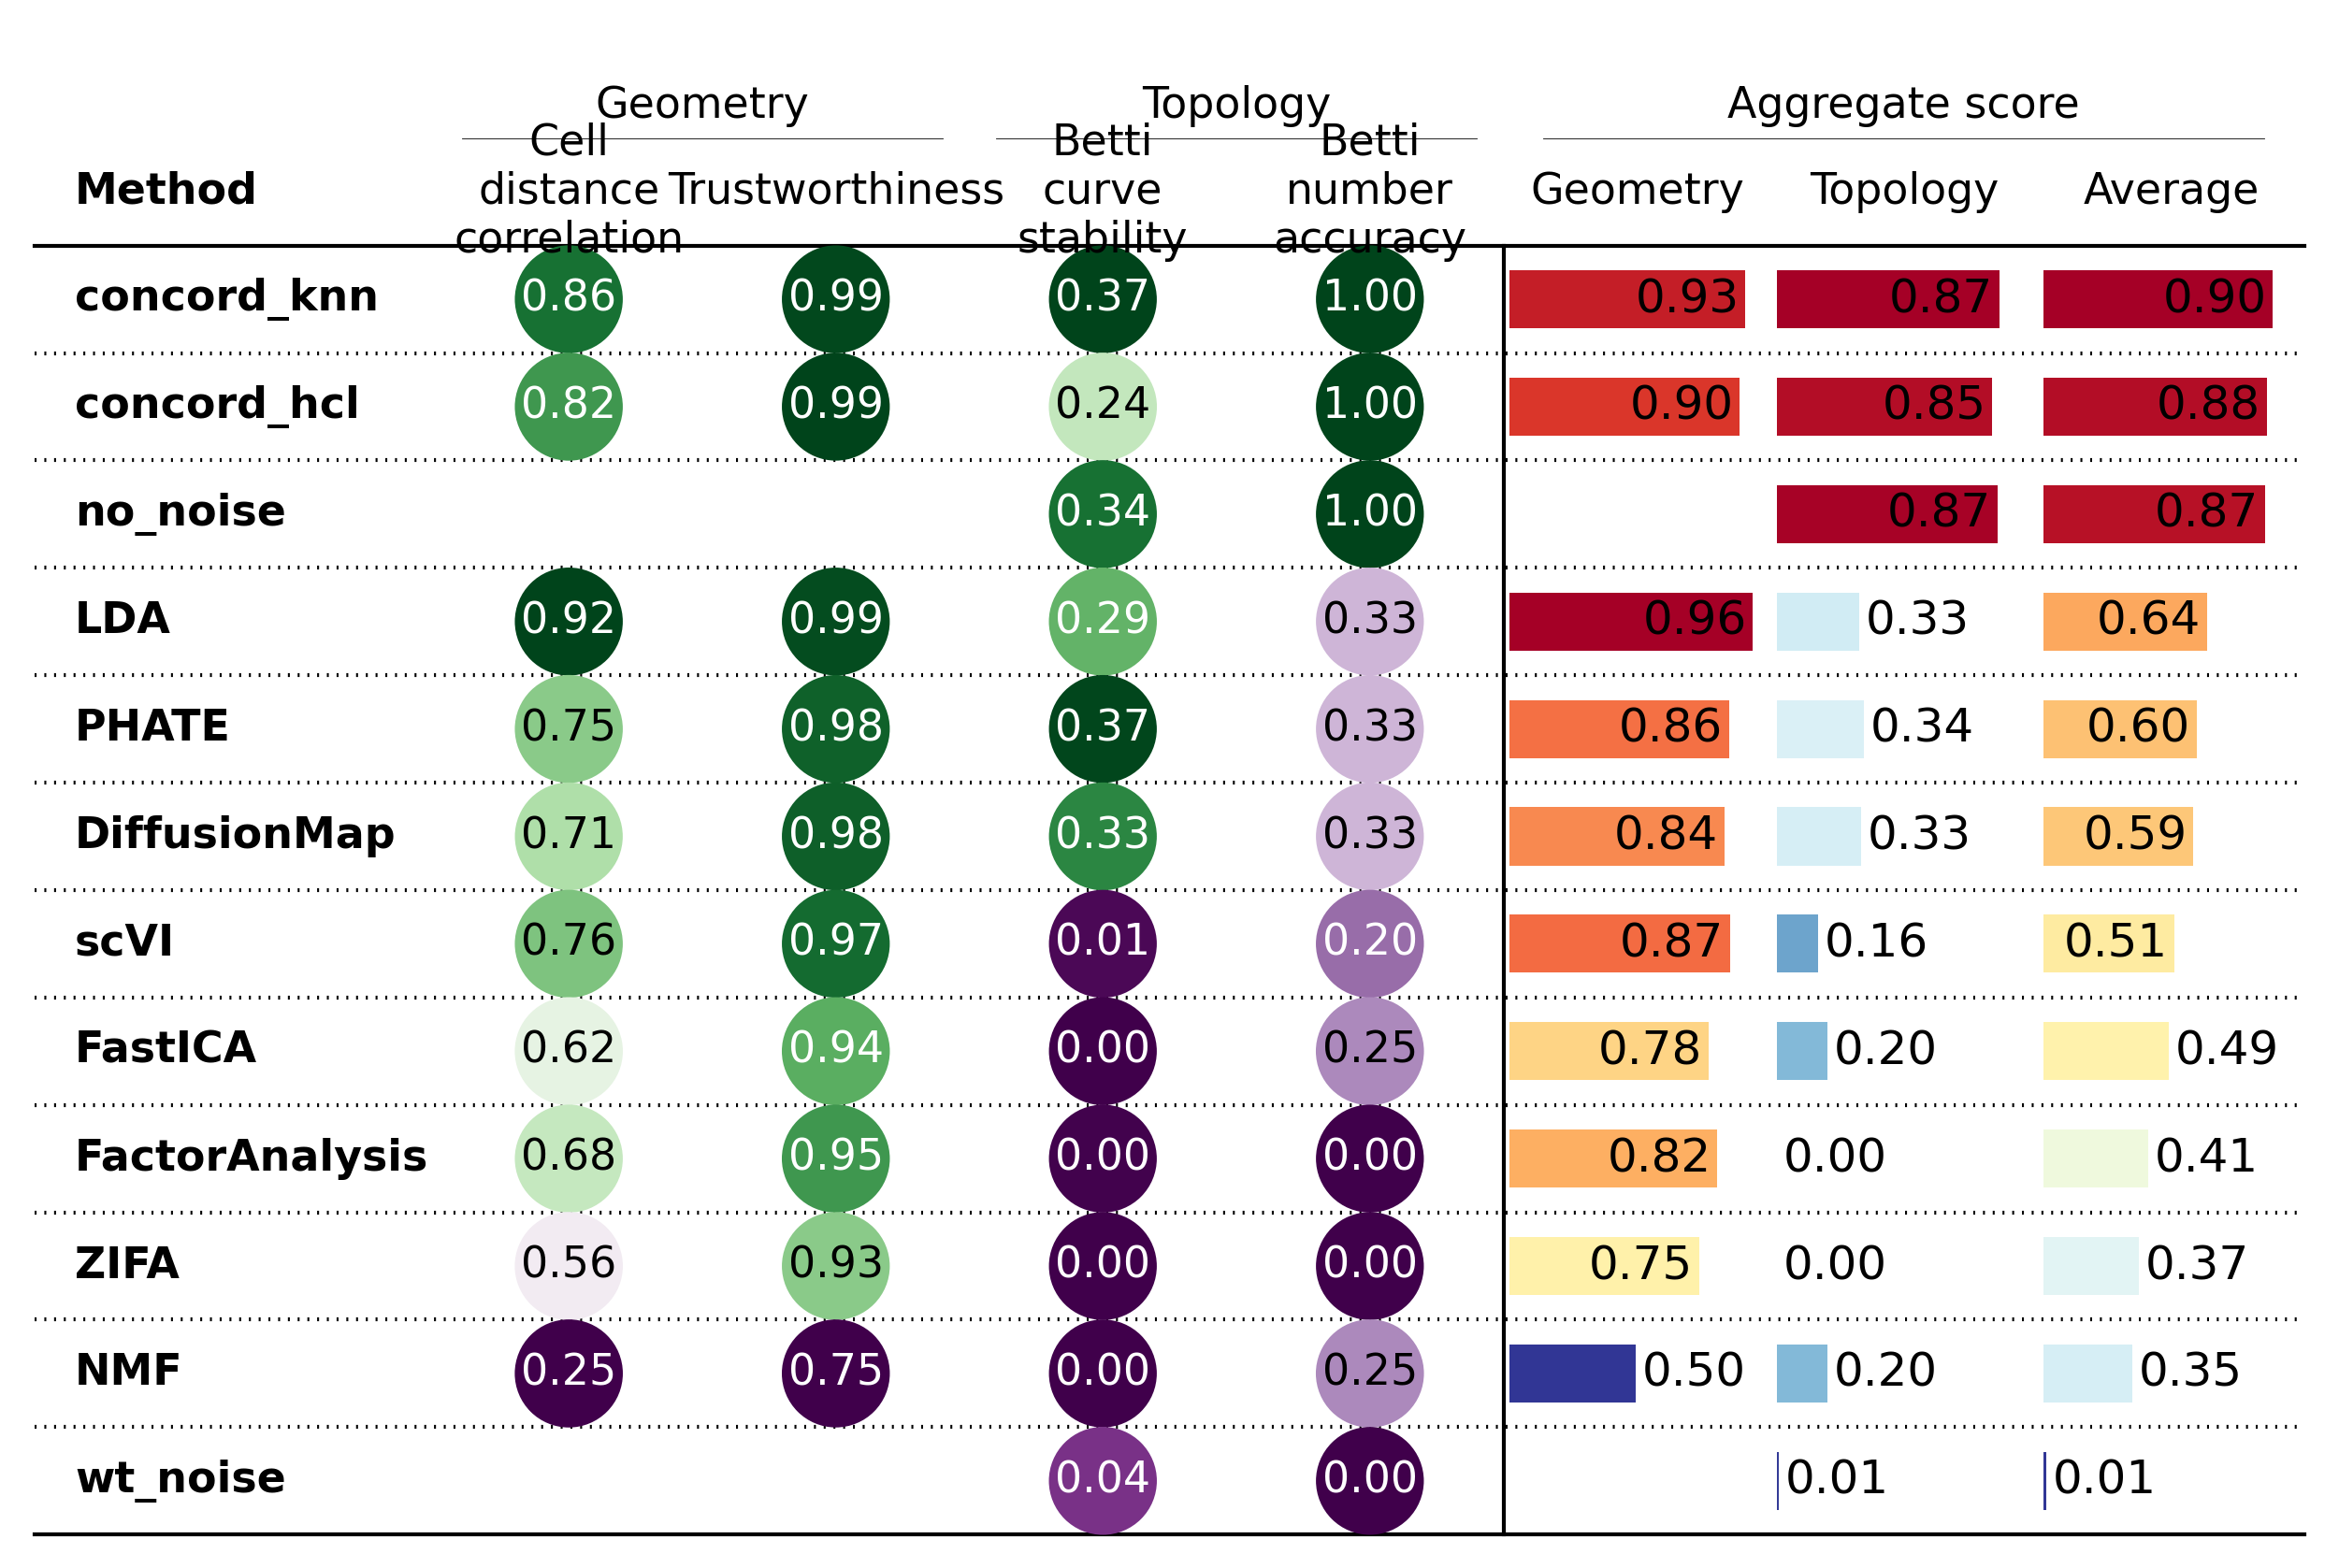

concord - INFO - Saved benchmark results to ../save/dev_simulation_complexloop_singlebatch-Aug25/benchmarks_out/benchmark_results_Aug25-1659.pkl


In [7]:
clean_keys = [k for k in combined_keys if k not in {"contrastive"}]

results = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=clean_keys,
    state_key=state_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    expected_betti_numbers=[0, 3, 0],
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("topology", "geometry"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    combine_plots=True,  # combine the plots into a single PDF
)

In [8]:
import pickle
with open(Path('../save/dev_simulation_complexloop_singlebatch-Aug25/benchmarks_out/benchmark_results_Aug25-1659.pkl'), 'rb') as f:
    results = pickle.load(f)
with open(Path('../save/dev_simulation_complexloop_singlebatch-Aug25/benchmarks_out/topology_diagrams_Aug25-1659.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open('../save/dev_simulation_complexloop_singlebatch-Aug25/benchmarks_out/geometry_results_Aug25-1659.pkl', 'rb'))


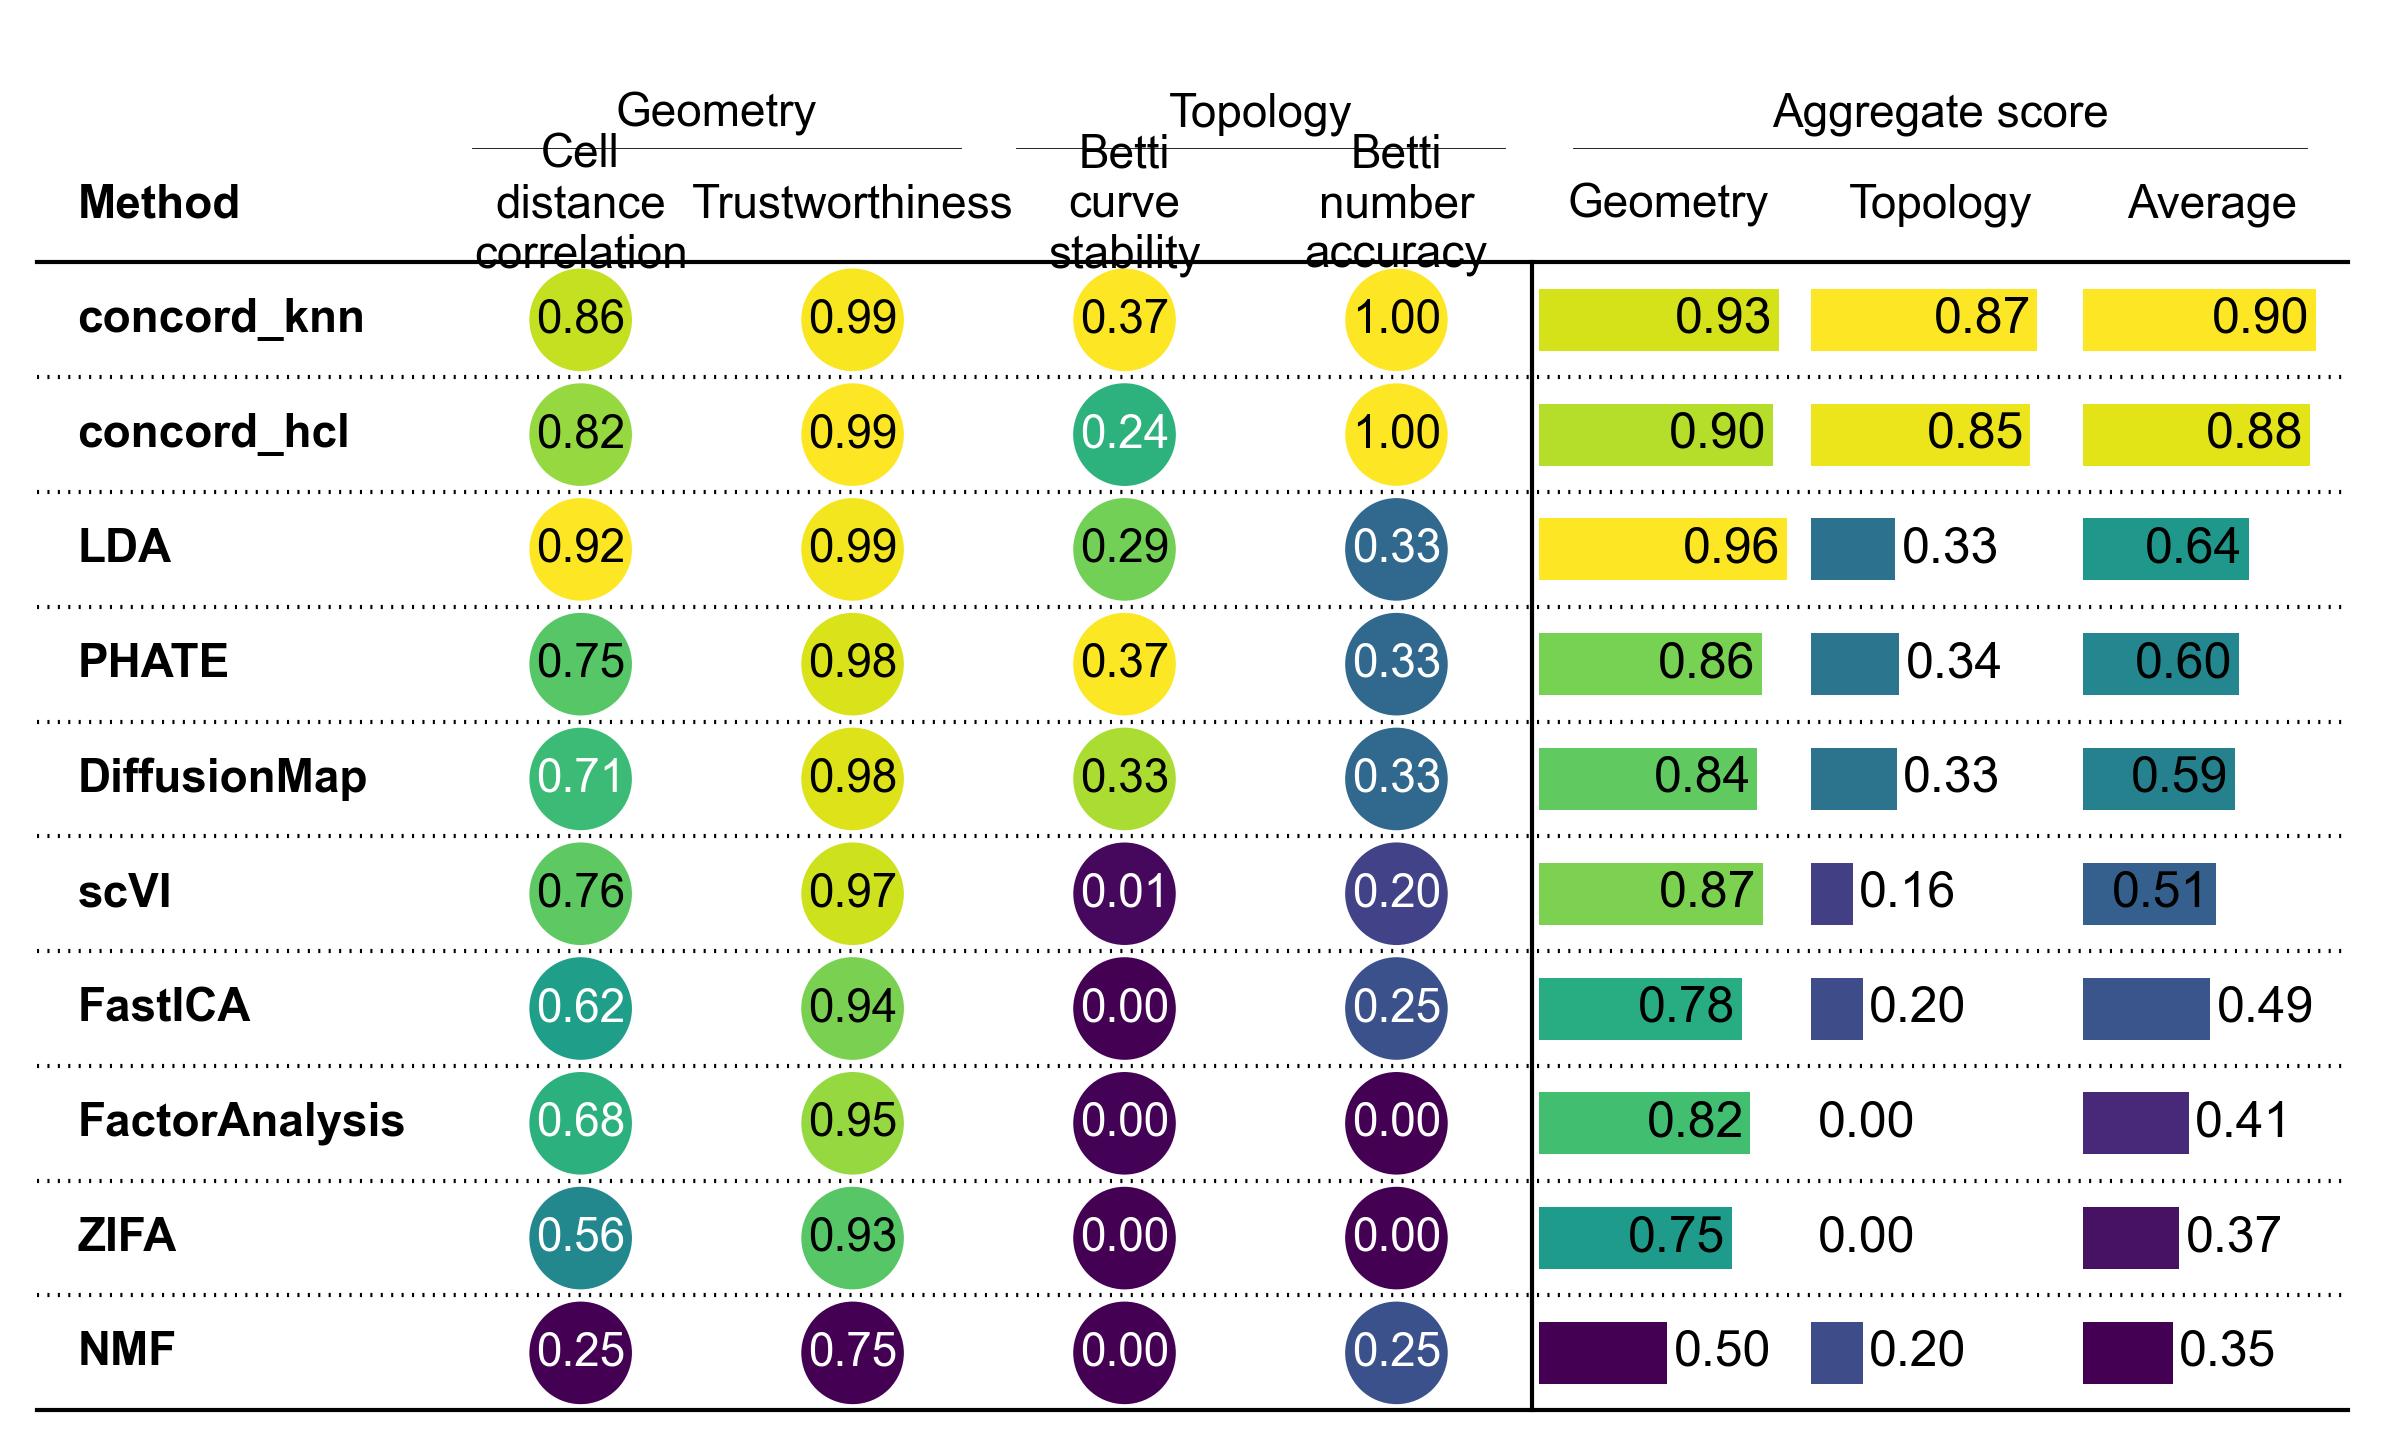

In [10]:
combined = results['combined']
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
        ccd.bm.plot_benchmark_table(
                combined.dropna(axis=0, how='any'),
                save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
                agg_name="Aggregate score",
                figsize=(10, 6),
                **table_plot_kw
                )

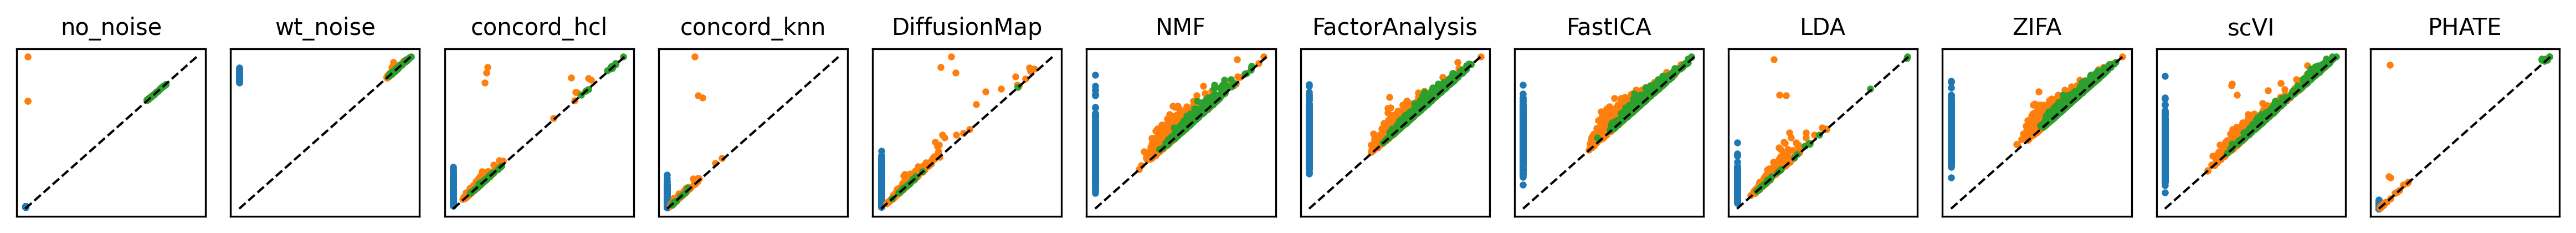

In [54]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in clean_keys if key in diagrams}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.svg", legend=False, label_axes=False, axis_ticks=False)

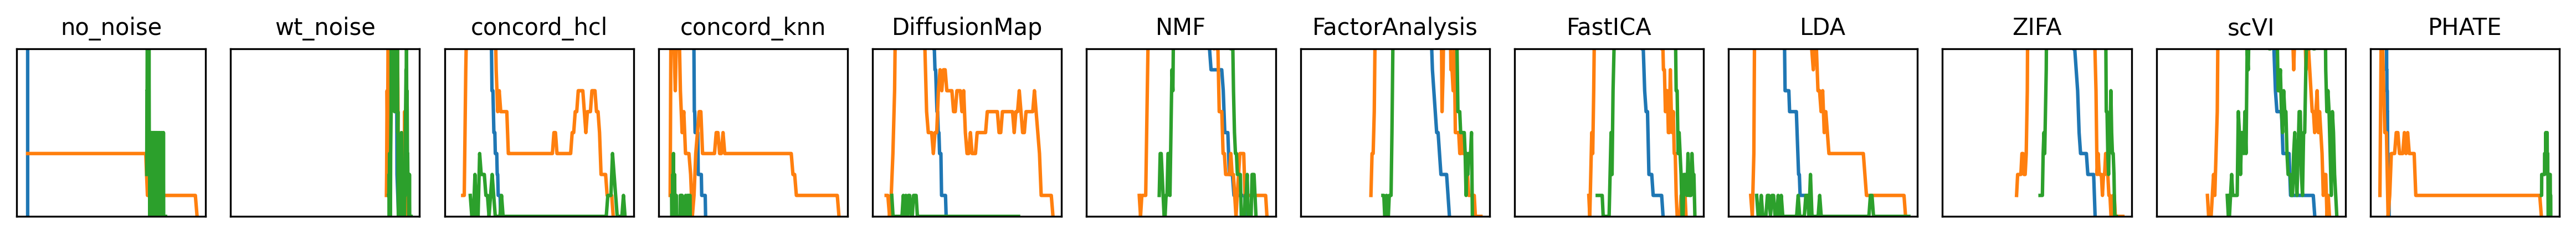

In [55]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

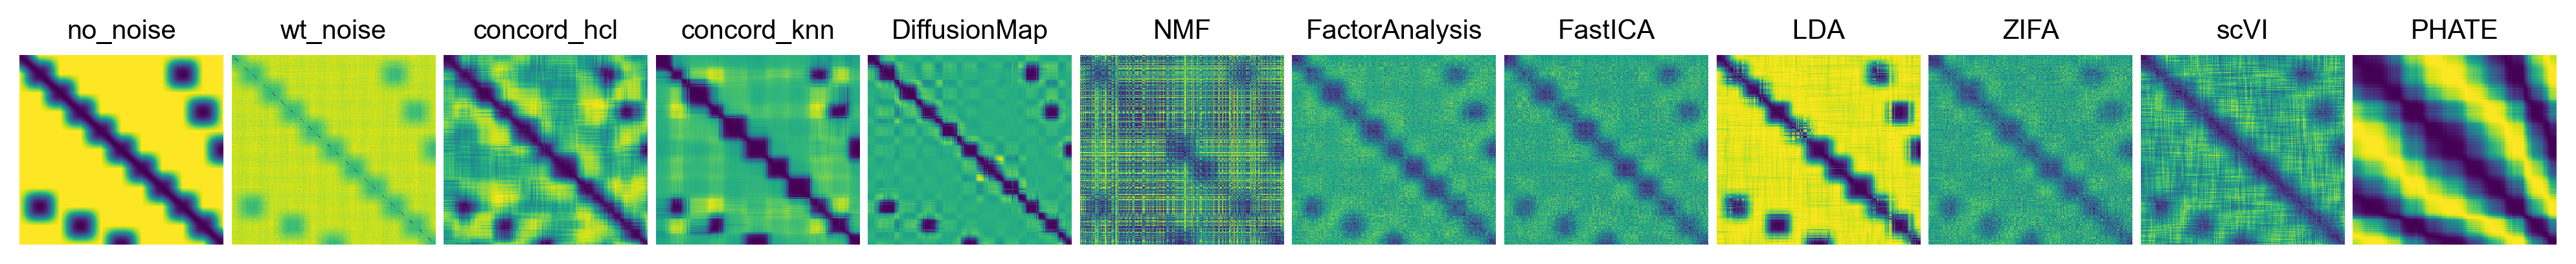

In [58]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

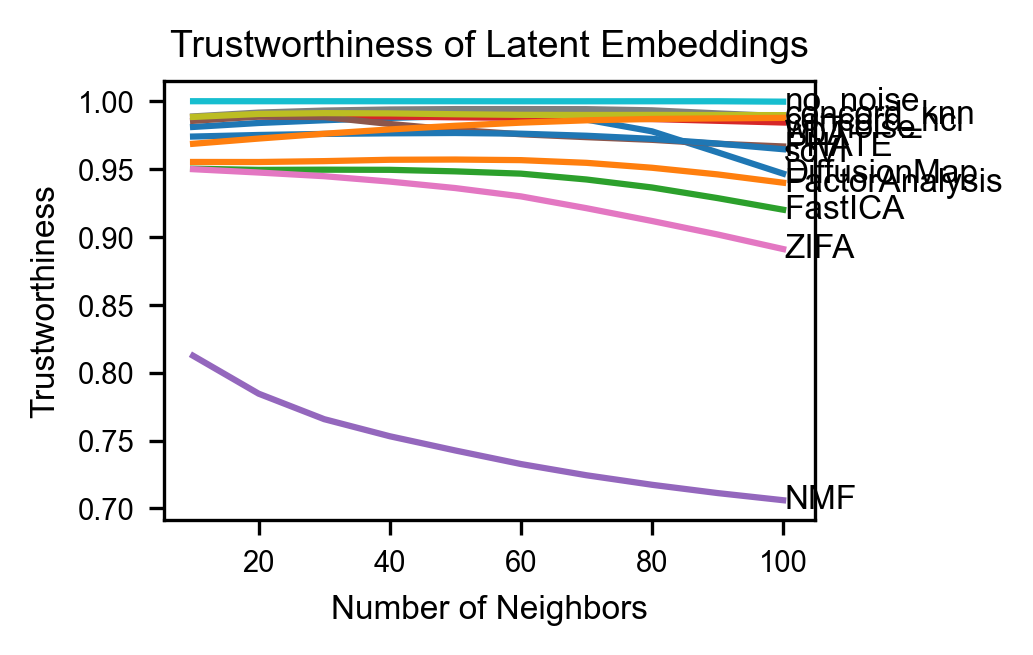

In [64]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = []
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=0.2, min_gap=0.005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(2.8,1.9))